<a href="https://colab.research.google.com/github/MiguelRegateiro/SI/blob/main/SIHeartAttack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB
Number of duplicate rows ::  (1, 14)
Number of duplicate rows ::  (0, 14)
Null values :: 
age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
old

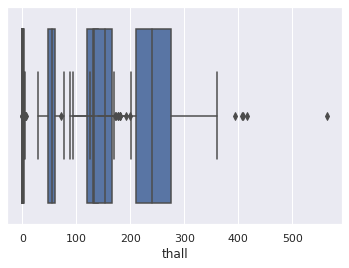

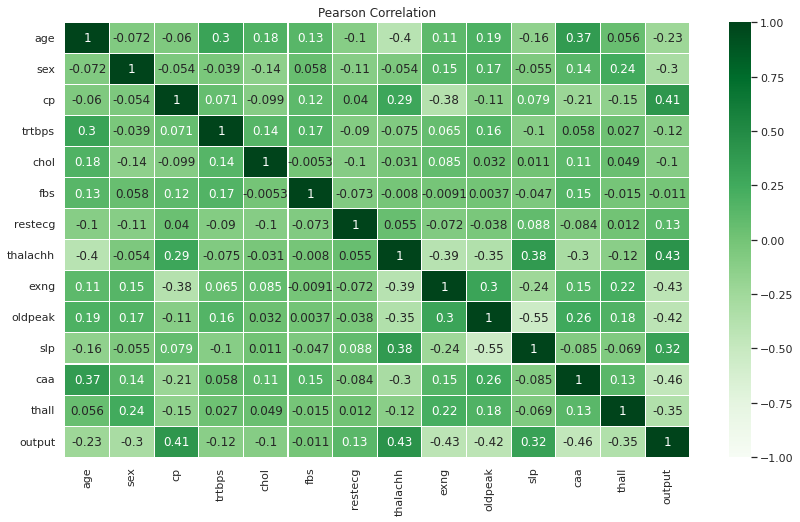

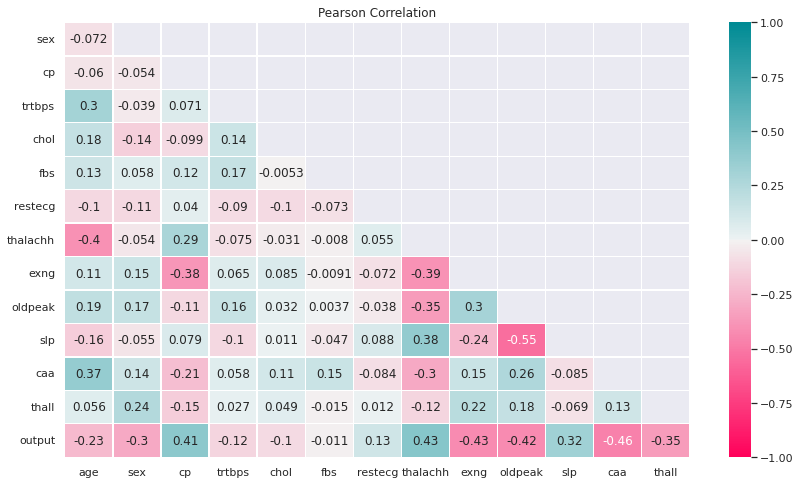

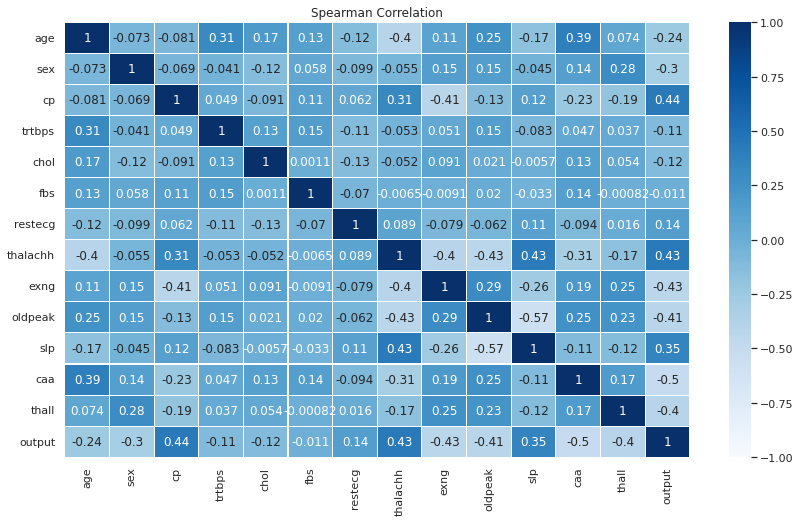

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(color_codes=True)
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier

data1 = pd.read_csv("https://raw.githubusercontent.com/MiguelRegateiro/SI/main/heart.csv")
data1 = pd.DataFrame(data1)

data1.info()

#number of records and features in the dataset
data1.shape

#DATA CLEANING

#Check duplicate rows in data
duplicate_rows = data1[data1.duplicated()]
print("Number of duplicate rows :: ", duplicate_rows.shape)

#we have one duplicate row.
#Removing the duplicate row
data1 = data1.drop_duplicates()
duplicate_rows = data1[data1.duplicated()]
print("Number of duplicate rows :: ", duplicate_rows.shape)
#Number of duplicate rows after dropping one duplicate row

#Looking for null values
print("Null values :: ")
print(data1.isnull() .sum())
#Check if the other data is consistent
data1.shape

#As there are no null values in data, we can proceed with the next steps.
#Detecting Outliers
# 1. Detecting Outliers using IQR (InterQuartile Range)
sns.boxplot(x=data1['age'])
#No Outliers observed in 'age'
sns.boxplot(x=data1['sex'])
#No outliers observed in sex data
sns.boxplot(x=data1['cp'])
#No outliers in 'cp'
sns.boxplot(x=data1['trtbps'])
#Some outliers are observed in 'trtbps'. They will be removed later
sns.boxplot(x=data1['chol'])
#Some outliers are observed in 'chol'. They will be removed later
sns.boxplot(x=data1['fbs'])
sns.boxplot(x=data1['restecg'])
sns.boxplot(x=data1['thalachh'])
#Outliers present in thalachh
sns.boxplot(x=data1['exng'])
sns.boxplot(x=data1['oldpeak'])
#Outliers are present in 'OldPeak'
sns.boxplot(x=data1['slp'])
sns.boxplot(x=data1['caa'])
#Outliers are present in 'caa'
sns.boxplot(x=data1['thall'])

#Find the InterQuartile Range
Q1 = data1.quantile(0.25)
Q3 = data1.quantile(0.75)
IQR = Q3-Q1
print('*********** InterQuartile Range ***********')
print(IQR)
# Remove the outliers using IQR
data2 = data1[~((data1<(Q1-1.5*IQR))|(data1>(Q3+1.5*IQR))).any(axis=1)]
data2.shape

#Removing outliers using Z-score
z = np.abs(stats.zscore(data1))
data3 = data1[(z<3).all(axis=1)]
data3.shape

#Finding the correlation between variables
pearsonCorr = data3.corr(method='pearson')
spearmanCorr = data3.corr(method='spearman')
fig = plt.subplots(figsize=(14,8))
sns.heatmap(pearsonCorr, vmin=-1,vmax=1, cmap = "Greens", annot=True, linewidth=0.1)
plt.title("Pearson Correlation")

#Create mask for both correlation matrices
#Pearson corr masking
#Generating mask for upper triangle
maskP = np.triu(np.ones_like(pearsonCorr,dtype=bool))
#Adjust mask and correlation
maskP = maskP[1:,:-1]
pCorr = pearsonCorr.iloc[1:,:-1].copy()
#Setting up a diverging palette
cmap = sns.diverging_palette(0, 200, 150, 50, as_cmap=True)
fig = plt.subplots(figsize=(14,8))
sns.heatmap(pCorr, vmin=-1,vmax=1, cmap = cmap, annot=True, linewidth=0.3, mask=maskP)
plt.title("Pearson Correlation")

fig = plt.subplots(figsize=(14,8))
sns.heatmap(spearmanCorr, vmin=-1,vmax=1, cmap = "Blues", annot=True, linewidth=0.1)
plt.title("Spearman Correlation")

#Create mask for both correlation matrices
#Spearson corr masking
#Generating mask for upper triangle
  #maskS = np.triu(np.ones_like(spearsonCorr,dtype=bool))
#Adjust mask and correlation
  #maskS = maskS[1:,:-1]
  #sCorr = spearsonCorr.iloc[1:,:-1].copy()
#Setting up a diverging palette
  #cmap = sns.diverging_palette(0, 250, 150, 50, as_cmap=True)
  #fig = plt.subplots(figsize=(14,8))
  #sns.heatmap(sCorr, vmin=-1,vmax=1, cmap = cmap, annot=True, linewidth=0.3, mask=maskS)
  #plt.title("Spearman Correlation")

#From this we observe that the minimum correlation between output and other features in
#fbs,trtbps and chol
x = data3.drop("output", axis=1)
y = data3["output"]
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3)

#Building classification models
names = ['Age', 'Sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh', 'exng', 'oldpeak', 'slp', 'caa', 'thall']
#   ****************Logistic Regression*****************
logReg = LogisticRegression(random_state=0, solver='liblinear')
logReg.fit(x_train, y_train)
#Check accuracy of Logistic Regression
y_pred_logReg = logReg.predict(x_test)
#Model Accuracy
print("Accuracy of logistic regression classifier :: " ,metrics.accuracy_score(y_test,y_pred_logReg))
#Removing the features with low correlation and checking effect on accuracy of model
x_train1 = x_train.drop("fbs",axis=1)
x_train1 = x_train1.drop("trtbps", axis=1)
x_train1 = x_train1.drop("chol", axis=1)
x_train1 = x_train1.drop("restecg", axis=1)
x_test1 = x_test.drop("fbs", axis=1)
x_test1 = x_test1.drop("trtbps", axis=1)
x_test1 = x_test1.drop("chol", axis=1)
x_test1 = x_test1.drop("restecg", axis=1)
logReg1 = LogisticRegression(random_state=0, solver='liblinear').fit(x_train1,y_train)
y_pred_logReg1 = logReg1.predict(x_test1)
print("nAccuracy of logistic regression classifier after removing features:: " ,metrics.accuracy_score(y_test,y_pred_logReg1))

# ***********************Decision Tree Classification***********************
decTree = DecisionTreeClassifier(max_depth=6, random_state=0)
decTree.fit(x_train,y_train)
y_pred_decTree = decTree.predict(x_test)
print("Accuracy of Decision Trees :: " , metrics.accuracy_score(y_test,y_pred_decTree))
#Remove features which have low correlation with output (fbs, trtbps, chol)
x_train_dt = x_train.drop("fbs",axis=1)
x_train_dt = x_train_dt.drop("trtbps", axis=1)
x_train_dt = x_train_dt.drop("chol", axis=1)
x_train_dt = x_train_dt.drop("age", axis=1)
x_train_dt = x_train_dt.drop("sex", axis=1)
x_test_dt = x_test.drop("fbs", axis=1)
x_test_dt = x_test_dt.drop("trtbps", axis=1)
x_test_dt = x_test_dt.drop("chol", axis=1)
x_test_dt = x_test_dt.drop("age", axis=1)
x_test_dt = x_test_dt.drop("sex", axis=1)
decTree1 = DecisionTreeClassifier(max_depth=6, random_state=0)
decTree1.fit(x_train_dt, y_train)
y_pred_dt1 = decTree1.predict(x_test_dt)
print("Accuracy of decision Tree after removing features:: ", metrics.accuracy_score(y_test,y_pred_dt1))

# Using Random forest classifier
rf = RandomForestClassifier(n_estimators=500)
rf.fit(x_train,y_train)
y_pred_rf = rf.predict(x_test)
print("Accuracy of Random Forest Classifier :: ", metrics.accuracy_score(y_test, y_pred_rf))
#Find the score of each feature in model and drop the features with low scores
f_imp = rf.feature_importances_
for i,v in enumerate(f_imp):
    print('Feature: %s, Score: %.5f' % (names[i],v))

#K Neighbours Classifier
knc =  KNeighborsClassifier()
knc.fit(x_train,y_train)
y_pred_knc = knc.predict(x_test)
print("Accuracy of K-Neighbours classifier :: ", metrics.accuracy_score(y_test,y_pred_knc))

#Models and their accuracy
print("*****************Models and their accuracy*****************")
print("Logistic Regression Classifier :: ", metrics.accuracy_score(y_test,y_pred_logReg1))
print("Decision Tree :: ", metrics.accuracy_score(y_test,y_pred_dt1))
print("Random Forest Classifier :: ", metrics.accuracy_score(y_test, y_pred_rf))
print("K Neighbours Classifier :: ", metrics.accuracy_score(y_test,y_pred_knc))
